# Long Short Term Memory Cell Neural Network with Tensorflow API

## Creating and Plotting the data

Give the model a series = [0, 0.84, 0.91, 0.14, -0.75, -0.96, -0.28] and see what the next is

Actually it is Sin(x)

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create a Class that will be able to create the data and also generate batches 
# to send back

class TimeSeriesData():
    
    def __init__(self, num_points, xmin, xmax):
        
        self.xmin = xmin
        self.xmax = xmax
        self.num_points = num_points
        
        self.resolution = (self.xmax - self.xmin)/self.num_points
        # Defining x for num_points points
        self.x_data = np.linspace(start = self.xmin,
                                  stop = self.xmax,
                                  num = self.num_points)
        # Getting the Sin(x) for all of the x_data points
        self.y_true = np.sin(self.x_data)
    
    # Returns the sin of an input array
    def ret_true(self, x_series):
        return np.sin(x_series)
    
    
    def next_batch(self, batch_size, steps, return_batch_time_series=False):
        
        # Grab a random starting point for each batch
        rand_start =np.random.rand(batch_size, 1)
        
        # Convert the random start to be lying somewhere on the time series
        time_series_start = rand_start * (self.xmax - self.xmin - (steps*self.resolution))
        
        # Create a batch time series on the x-axis
        batch_time_series = time_series_start + np.arange(0.0, steps+1) * self.resolution
        
        # Create a corresponding y_data for each of the x_data points
        y_batch = np.sin(batch_time_series)
        
        # Format the whole thing for RNN
        if return_batch_time_series:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), batch_time_series
        else:
            # first batch represents the time series, second batch reprersents the 
            # series shifted over by one step into the future so we can train
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
        

In [3]:
# Creating Data
ts_data = TimeSeriesData(num_points=250, xmin=0, xmax=10)

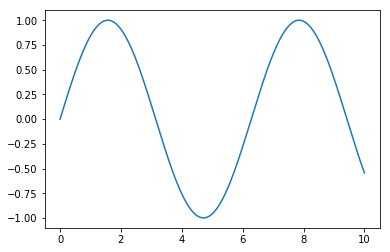

In [4]:
# Plotting the data
plt.plot(ts_data.x_data, ts_data.y_true);

In [5]:
# Each of my random batches should have 30 steps in it
num_time_steps = 30

In [6]:
# I need 1 batch of 30 time steps with the batch time series
y1, y2, ts = ts_data.next_batch(batch_size=1, steps=num_time_steps, return_batch_time_series=True)

In [7]:
ts

array([[1.44010061, 1.48010061, 1.52010061, 1.56010061, 1.60010061,
        1.64010061, 1.68010061, 1.72010061, 1.76010061, 1.80010061,
        1.84010061, 1.88010061, 1.92010061, 1.96010061, 2.00010061,
        2.04010061, 2.08010061, 2.12010061, 2.16010061, 2.20010061,
        2.24010061, 2.28010061, 2.32010061, 2.36010061, 2.40010061,
        2.44010061, 2.48010061, 2.52010061, 2.56010061, 2.60010061,
        2.64010061]])

In [8]:
ts.shape

(1, 31)

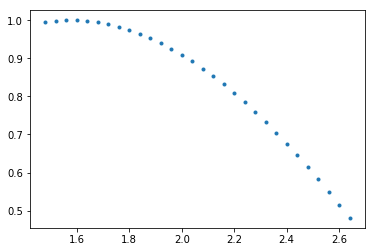

In [9]:
# Plotting
plt.plot(ts.flatten()[1:], y2.flatten(), '.');

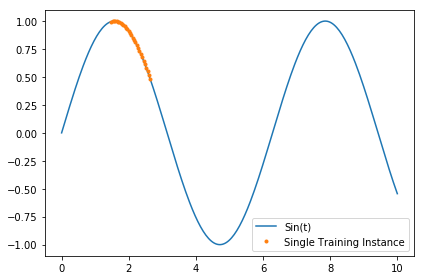

In [10]:
# Original Sine wave
plt.plot(ts_data.x_data, ts_data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '.', label='Single Training Instance')
plt.legend()
plt.tight_layout() # automatic padding for legibility

In [11]:
# Training Data

train_inst = np.linspace(5, 5 + ts_data.resolution*(num_time_steps+1), num_time_steps+1)
train_inst

array([5.        , 5.04133333, 5.08266667, 5.124     , 5.16533333,
       5.20666667, 5.248     , 5.28933333, 5.33066667, 5.372     ,
       5.41333333, 5.45466667, 5.496     , 5.53733333, 5.57866667,
       5.62      , 5.66133333, 5.70266667, 5.744     , 5.78533333,
       5.82666667, 5.868     , 5.90933333, 5.95066667, 5.992     ,
       6.03333333, 6.07466667, 6.116     , 6.15733333, 6.19866667,
       6.24      ])

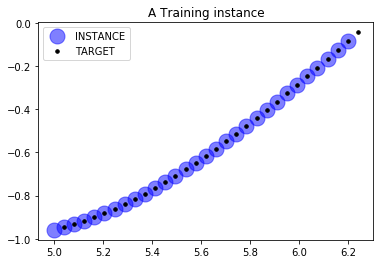

In [12]:
plt.title("A Training instance")
plt.plot(train_inst[:-1], ts_data.ret_true(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, 
        label='INSTANCE');
# We need to predict exactly one time step forward
plt.plot(train_inst[1:],ts_data.ret_true(train_inst[1:]), 'k.', markersize=7, label='TARGET')
plt.legend();

Now this graph is interpreted as - Given the blue points, can you generate the black points?

## Creating the Model

In [13]:
# Uncomment below line if using GPUs
# tf.reset_default_graph() # Obligatory

In [14]:
# DESIGNING THE NETWORK OUTLINE
num_inputs = 1 # We only have one feature ie the value of x
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_training_iterations = 2000
batch_size = 1

# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# LSTM CELL LAYER
cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,
                                   activation=tf.nn.relu)
# Tha above is deprecated. Using tf.keras instead
# cell = tf.keras.layers.LSTMCell(units=num_neurons, activation=tf.nn.relu, use_bias=True,
#                                 unit_forget_bias=True)

# We just need 1 time series output, we are using 100 neurons, but we dont need 100 outputs
# So we use an output projection wrapper (Check docstring again for more details)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)
# Creating a Recurrent NeuralNet specified by the cell (has to be RNN Cell)
# Note: this is deprecated, will need to run keras.layers.RNN(cell) which is equivalent
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)
# Using the updated keras.layers.rnn instead of the above
# outputs, states = tf.keras.layers.LSTM(cell=cell, inputs=X, dtype=tf.float32) #NOT WORKING


# LOSS FUNCTION:
# Using Mean Squared Error: between outputs and the placeholder y of true labels
loss = tf.reduce_mean(tf.square(outputs-y))

# OPTIMIZER and TRAINING OBJECT
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999,
                                  epsilon=1e-08)
# Note: SGD with Nesterov and simple annealing with eta=0.001 also works
train = optimizer.minimize(loss)

# CREATING GLOBAL VARIBALE INITIALIZER OBJECT FOR THE VARIBALES
init = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


## Running the Session

In [15]:
# SESSION

# Note: Uncomment below line if using GPUs
# To limit the memory usage of GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

# Saver function to save my model to use later
saver = tf.train.Saver()

# Uncomment this Session() mainloop if using GPUs
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    # Initialize the Variables
    sess.run(init)
    
    for iteration in range(num_training_iterations):
        # Get the next batch
        X_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)
        # Running the session with the current batch
        # On the train object designed to minimize the MSE with AdamOptimization
        sess.run(train, feed_dict={
            X: X_batch,
            y: y_batch
        })
        # Calculating the accuracy every 100 steps and report back
        if iteration%10 == 0:
            # Calculating the loss on the training set
            mse = loss.eval(feed_dict={
                X: X_batch,
                y: y_batch
            })
            print(iteration, "\tMSE: ", mse)
    saver.save(sess, "./TF_LSTM_Adam_NoGPU")

0 	MSE:  0.25732213
10 	MSE:  0.53203255
20 	MSE:  0.73086524
30 	MSE:  0.8049107
40 	MSE:  0.24642436
50 	MSE:  0.66105455
60 	MSE:  0.5858784
70 	MSE:  0.62557465
80 	MSE:  0.67872894
90 	MSE:  0.63797855
100 	MSE:  0.099279374
110 	MSE:  0.42395183
120 	MSE:  0.419262
130 	MSE:  0.15022378
140 	MSE:  0.52035695
150 	MSE:  0.3342901
160 	MSE:  0.07076002
170 	MSE:  0.24411121
180 	MSE:  0.12954417
190 	MSE:  0.26609293
200 	MSE:  0.09373483
210 	MSE:  0.10117997
220 	MSE:  0.2116181
230 	MSE:  0.34116203
240 	MSE:  0.28711018
250 	MSE:  0.061505493
260 	MSE:  0.11863293
270 	MSE:  0.05324018
280 	MSE:  0.16726772
290 	MSE:  0.04861739
300 	MSE:  0.13559279
310 	MSE:  0.036272984
320 	MSE:  0.15809222
330 	MSE:  0.15316023
340 	MSE:  0.11258095
350 	MSE:  0.062795244
360 	MSE:  0.0642047
370 	MSE:  0.045939077
380 	MSE:  0.06473942
390 	MSE:  0.16387205
400 	MSE:  0.03747544
410 	MSE:  0.083948456
420 	MSE:  0.038323916
430 	MSE:  0.024281295
440 	MSE:  0.10830282
450 	MSE:  0.1236258

## Predict the time series one step into the future

In [16]:
with tf.Session() as sess:
    
    # restore the saved model
    saver.restore(sess, "./TF_LSTM_Adam_NoGPU")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./TF_LSTM_Adam_NoGPU


In [17]:
y_pred.flatten()

array([-0.14760563, -0.31470042, -0.47798008, -0.6284207 , -0.75691843,
       -0.8535121 , -0.9131032 , -0.9384186 , -0.9341582 , -0.9062667 ,
       -0.8624424 , -0.8085889 , -0.74983275, -0.69138175, -0.63596195,
       -0.5844569 , -0.5382446 , -0.49741304, -0.46055695, -0.4264668 ,
       -0.39392686, -0.36141023, -0.32769752, -0.29173803, -0.25237924,
       -0.21001765, -0.164742  , -0.11635915, -0.06440131, -0.00808681],
      dtype=float32)

## Plotting the result

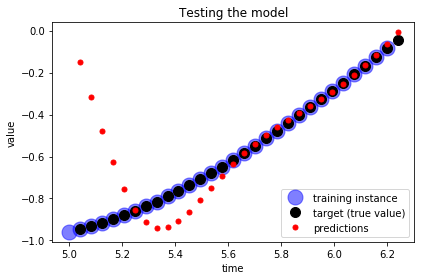

In [18]:
plt.title("Testing the model")
# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", 
         markersize=15, alpha=0.5, label='training instance')

# Target to predict (True test values ie np.sin(train))
# ie Time Series shifted one step into the future
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label='target (true value)')

# Model prediction
plt.plot(train_inst[1:],  y_pred[0,:,0], 'r.', markersize=10, label='predictions')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.tight_layout();

Wow, Using LSTM with a lesser learning rate actually decreased the accuracy

# Note on the sequence of execution

Note to self

Continuing the execution from here is giving me an error at the tf.nn.dynamic_rnn() line 25

So, instead, I restarted the kernel, ran the data creation section again and instead of modeling from above, started from the below cells. Maybe a problem with reusing a variable. Dont have time to confirm.

## Trying again with a higher learning rate of 0.001 instead of 0.0001

In [13]:
# DESIGNING THE NETWORK OUTLINE
num_inputs = 1 # We only have one feature ie the value of x
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_training_iterations = 2000
batch_size = 1

# PLACEHOLDERS
X = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

# LSTM CELL LAYER
cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons,
                                   activation=tf.nn.relu)
# Tha above is deprecated. Using tf.keras instead
# cell = tf.keras.layers.LSTMCell(units=num_neurons, activation=tf.nn.relu, use_bias=True,
#                                 unit_forget_bias=True)

# We just need 1 time series output, we are using 100 neurons, but we dont need 100 outputs
# So we use an output projection wrapper (Check docstring again for more details)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)
# Creating a Recurrent NeuralNet specified by the cell (has to be RNN Cell)
# Note: this is deprecated, will need to run keras.layers.RNN(cell) which is equivalent
outputs, states = tf.nn.dynamic_rnn(cell=cell, inputs=X, dtype=tf.float32)
# Using the updated keras.layers.rnn instead of the above
# outputs, states = tf.keras.layers.LSTM(cell=cell, inputs=X, dtype=tf.float32) #NOT WORKING


# LOSS FUNCTION:
# Using Mean Squared Error: between outputs and the placeholder y of true labels
loss = tf.reduce_mean(tf.square(outputs-y))

# OPTIMIZER and TRAINING OBJECT
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999,
                                  epsilon=1e-08)
# Note: SGD with Nesterov and simple annealing with eta=0.001 also works
train = optimizer.minimize(loss)

# CREATING GLOBAL VARIBALE INITIALIZER OBJECT FOR THE VARIBALES
init = tf.global_variables_initializer()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.


In [14]:
# SESSION

# Note: Uncomment below line if using GPUs
# To limit the memory usage of GPU
# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)

# Saver function to save my model to use later
saver = tf.train.Saver()

# Uncomment this Session() mainloop if using GPUs
# with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
with tf.Session() as sess:
    # Initialize the Variables
    sess.run(init)
    
    for iteration in range(num_training_iterations):
        # Get the next batch
        X_batch, y_batch = ts_data.next_batch(batch_size=batch_size, steps=num_time_steps)
        # Running the session with the current batch
        # On the train object designed to minimize the MSE with AdamOptimization
        sess.run(train, feed_dict={
            X: X_batch,
            y: y_batch
        })
        # Calculating the accuracy every 100 steps and report back
        if iteration%10 == 0:
            # Calculating the loss on the training set
            mse = loss.eval(feed_dict={
                X: X_batch,
                y: y_batch
            })
            print(iteration, "\tMSE: ", mse)
    saver.save(sess, "./TF_LSTM_Adam_NoGPU_higher_Eta")

0 	MSE:  0.59842205
10 	MSE:  0.17359935
20 	MSE:  0.22567816
30 	MSE:  0.36930677
40 	MSE:  0.31717417
50 	MSE:  0.15337557
60 	MSE:  0.123921715
70 	MSE:  0.074231625
80 	MSE:  0.1836071
90 	MSE:  0.101253405
100 	MSE:  0.043664377
110 	MSE:  0.02800739
120 	MSE:  0.07123113
130 	MSE:  0.056542385
140 	MSE:  0.041583497
150 	MSE:  0.075794496
160 	MSE:  0.08765469
170 	MSE:  0.011890696
180 	MSE:  0.036370017
190 	MSE:  0.030621316
200 	MSE:  0.06115421
210 	MSE:  0.032723777
220 	MSE:  0.05434861
230 	MSE:  0.037499413
240 	MSE:  0.04970654
250 	MSE:  0.0077667404
260 	MSE:  0.041216314
270 	MSE:  0.038585458
280 	MSE:  0.009107788
290 	MSE:  0.042877097
300 	MSE:  0.03853797
310 	MSE:  0.0045101065
320 	MSE:  0.037947338
330 	MSE:  0.026311155
340 	MSE:  0.0068549057
350 	MSE:  0.03313675
360 	MSE:  0.023889719
370 	MSE:  0.0049904077
380 	MSE:  0.002491073
390 	MSE:  0.023886243
400 	MSE:  0.02548018
410 	MSE:  0.020718418
420 	MSE:  0.023110835
430 	MSE:  0.030119607
440 	MSE:  0

Preveously the error was much higher than the current error with the higher learning rate

## Again Predicting One TimeStep into the Future

In [15]:
with tf.Session() as sess:
    
    # restore the saved model
    saver.restore(sess, "./TF_LSTM_Adam_NoGPU_higher_Eta")
    
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./TF_LSTM_Adam_NoGPU_higher_Eta


## Plotting the Final Result

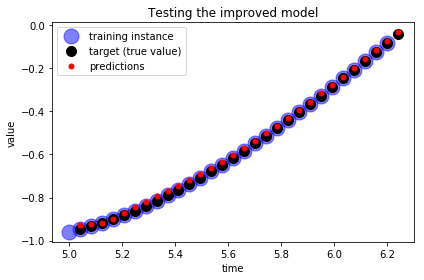

In [16]:
plt.title("Testing the improved model")
# Training instance
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), "bo", 
         markersize=15, alpha=0.5, label='training instance')

# Target to predict (True test values ie np.sin(train))
# ie Time Series shifted one step into the future
plt.plot(train_inst[1:], np.sin(train_inst[1:]), "ko", markersize=10, label='target (true value)')

# Model prediction
plt.plot(train_inst[1:],  y_pred[0,:,0], 'r.', markersize=10, label='predictions')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.tight_layout();

This is way better than that preveously plotted mess.